# Importing Dependencies

In [178]:
# Task B2
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os

# Task B3
import plotly.graph_objects as go
import plotly.express as px

# Task B4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,SimpleRNN,LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import sys

# Task B6
from statsmodels.tsa.arima_model import ARIMA


# Hyperparameters

In [179]:
# Task B2
TICKER = "AAPL"
START_DATE = "2010-01-01"
END_DATE = "2023-12-31"
LOOK_UP_DAYS = 2
TRAINING_RATIO = 0.8    # 0.7 == 70%
SCALE_DATA = True
SCALING_METHOD = "MinMax"       # MinMax, Standard

# Task B3
TRADING_PERIOD = 60
CONSECUTIVE_DAYS = 300

# Task B4
NUMBER_OF_LAYER = 2
NUMBER_OF_HIDDEN_UNITS = 200
MODEL_NAME = "LSTM"      ## "RNN". "LSTM", "GRU"
DROP_OUT_RATE = 0     ## dropout rate in [0,1]
NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 12
FEATURE_PREDICT = "Close"    ## "Open", "High", "Close", "Low"
LOSS_FUNCTION = "mean_squared_error" ## "mean_squared_error", "mean_absolute_error", "huber_loss"
OPTIMIZER = "adam"  ## "adam", "RMSprop", "SGD"


# Task B2: DATA PROCESSING 1

## Scaling dataset

In [180]:
def DataScaler(stock_data, scaling_method=SCALING_METHOD):

    DatasetScaler = None
    ColumnScalers = {

    }
    if scaling_method == "MinMax":
        DatasetScaler = preprocessing.MinMaxScaler()


    elif scaling_method == "Standard":
        DatasetScaler = preprocessing.StandardScaler()


    # Learn the whole dataset
    col_names = stock_data.columns
    features = stock_data[col_names]
    DatasetScaler.fit(features.values)
    features = DatasetScaler.transform(features.values)
    scaledDataFrame = pd.DataFrame(features, columns = col_names)
    scaledDataFrame.index = stock_data.index

    for column in col_names:
        column_scaler = None
        if scaling_method == "MinMax":
            column_scaler = preprocessing.MinMaxScaler()
        elif scaling_method == "Standard":
            column_scaler = preprocessing.StandardScaler()
        column_scaler.fit(stock_data[column].values.reshape(-1,1))
        ColumnScalers[column] = column_scaler

    return scaledDataFrame, DatasetScaler, ColumnScalers


## Loading Data Function

In [181]:
def DataLoader(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, scale=SCALE_DATA, scaling_method=SCALING_METHOD):
    '''
    ticker: is the code of the target ticker
    start_date: a start date string with format YYYY/MM/DD
    end_date: an end date string with format YYYY/MM/DD
    scale: a boolean value, True by default
    scaling_method: MinMax(by default), Standard.
    '''

    # result
    result = {
        "dataset": None,
        "datasetScaler": None,
        "columnScalers": None
    }

    # processing the input parameters
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")


    # creating necessary folder
    if not os.path.isdir("results"):
        os.mkdir("results")

    if not os.path.isdir("data"):
        os.mkdir("data")



    # checking if the data is already downloaded
    ## Get a list of files in the directory
    files = os.listdir("data")
    ## Check each file in the directory
    data = None
    for file_name in files:
        ## if we already downloaded the ticket data
        if file_name.startswith(ticker) and file_name.endswith(".csv"):
            ### Read the file
            file_path = os.path.join("data", f"{ticker}.csv")
            data = pd.read_csv(file_path, parse_dates=['Date'])
            break

    ## else, we gonna download the stock data
    if data is None:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])

    # if the given time is included in the file, we just take the nessecary dataframe
    if data.head(1)["Date"].values[0] <= np.datetime64(start_date) and data.tail(1)["Date"].values[0] >= np.datetime64(end_date):
        data = data[(data['Date'] >= pd.to_datetime(start_date)) & (data['Date'] <= pd.to_datetime(end_date))]
        print("Local Stock Data is enough for requirements, do not need to download")
    else:
        stock_data = yf.download(ticker, start_date, end_date)
        file_path = os.path.join("data", f"{ticker}.csv")
        stock_data.to_csv(file_path)
        data = pd.read_csv(file_path, parse_dates=['Date'])
        print("Local Stock Data is not enough for requirements, continuing downloading...")

    # Setting Date as Index
    data.set_index('Date', inplace=True)

    # Scale Data
    if scale:
        data, scaler, column_scalers = DataScaler(data, scaling_method)
        result["dataset"] = data
        result["datasetScaler"] = scaler
        result["columnScalers"] = column_scalers
        return result

    result["dataset"] = data

    return result

## Splitting Dataset

In [182]:
def datasetSplitter(dataset: pd.DataFrame, look_up_days=LOOK_UP_DAYS,
        training_ratio=TRAINING_RATIO,
        feature_columns=['Open','High','Low','Close','Adj Close','Volume']):
    '''
    dataset: a Pandas Dataframe
    training_ratio: is equal to TRAINING_RATION constant
    '''
    # result
    splitResult = {
        "X_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_training_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "X_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        },
        "Y_testing_set": {
                        'Open': None,
                        'High': None,
                        'Low': None,
                        'Close': None,
                        'Adj Close': None,
                        'Volume': None
                        }
    }

    for column in feature_columns:
        dataset_in_column = dataset[column].values.reshape(-1, 1)      # <class 'numpy.ndarray'>
        x_data = []
        y_data = []

        for x in range(look_up_days, len(dataset_in_column)):
            x_data.append(dataset_in_column[x - look_up_days:x, 0])
            y_data.append(dataset_in_column[x, 0])

        splitResult["X_training_set"][column], splitResult["X_testing_set"][column], splitResult["Y_training_set"][column], splitResult['Y_testing_set'][column] = train_test_split(x_data, y_data, test_size=1-training_ratio, shuffle=False)

        ## Converting to numpy.array

        for column in feature_columns:
            splitResult["X_training_set"][column] = np.array(splitResult["X_training_set"][column])
            splitResult["Y_training_set"][column] = np.array(splitResult["Y_training_set"][column])
            splitResult["X_testing_set"][column] = np.array(splitResult["X_testing_set"][column])
            splitResult["Y_testing_set"][column] = np.array(splitResult["Y_testing_set"][column])

    return splitResult

## Data Processing 1 (FULL)

A function to load and process a dataset with multiple features with the following requirements:

+ Specify the start date and the end date for the whole
dataset as inputs.
+ Allowing you to deal with the NaN issue in the data
+ Splitting dataset according to some specified ratio of train/test
+ Storing the downloaded data on your local machine for future uses
+ Allowing you to have an option to scale your feature columns and store the scalers in a data structure to allow future access to these scalers.

In [183]:
def Data_Processing_1():
    dataLoader = DataLoader()

    scaledStockData = dataLoader["dataset"]
    datasetScaler = dataLoader["datasetScaler"]
    columnScalers = dataLoader["columnScalers"]

    dataset = datasetSplitter(dataset=scaledStockData)

    print("Loaded Done!\nThe result is a tuple as below:\n")
    print("(dataset, scaledStockData, datasetScaler, columnScalers), where:\n")
    print("dataset is a dictionary as below:")
    print('''{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ...,
                        'Low': ...,
                        ...
                        }
    }\n''')
    print("scaledStockData is a Pandas Dataframe of the Stock Ticker (scaled)\n")
    print("datasetScaler is the Scaler of the dataset\n")
    print("columnScalers is a dictionary: each key is a DataFrame Feature('Open', 'High', etc.) and the correspond value is a scaler of that feature")
    return dataset, scaledStockData, datasetScaler, columnScalers


In [184]:
dataset, scaledStockData, datasetScaler, ColumnScalers  = Data_Processing_1()

[*********************100%%**********************]  1 of 1 completed

Local Stock Data is not enough for requirements, continuing downloading...
Loaded Done!
The result is a tuple as below:

(dataset, scaledStockData, datasetScaler, columnScalers), where:

dataset is a dictionary as below:
{
        "X_training_set": {
                        'Open': <class 'numpy.ndarray'>,
                        'High': <class 'numpy.ndarray'>,
                        'Low': <class 'numpy.ndarray'>,
                        'Close': <class 'numpy.ndarray'>,
                        'Adj Close': <class 'numpy.ndarray'>,
                        'Volume': <class 'numpy.ndarray'>
                        },
        "Y_training_set": {
                        'Open': ...,
                        ...
                        },
        "X_testing_set": {
                        'Open': ...,
                        'High': ...,
                        ...
                        },
        "Y_testing_set": {
                        'Open': ...,
                        'High': ..

# Task B3: DATA PROCESSING 2

## Inverse Data

In [185]:
def datasetInverser(scaledStockData, datasetScaler):

    # Getting Column name
    col_names = scaledStockData.columns
    # Inversing the dataframe
    re_scaled_features = datasetScaler.inverse_transform(scaledStockData)
    re_scaled_stock_data = pd.DataFrame(re_scaled_features, columns = col_names)
    # Assigning index to the rescaled_data
    re_scaled_stock_data.index = scaledStockData.index


    ## A Pandas Dataframe
    return re_scaled_stock_data


## Candlestick Chart

In [186]:
def CandleStick(dataset, datascaler,TradingPeriod=TRADING_PERIOD):

    # Loading the dataset
    original_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        original_data = datasetInverser(dataset, datascaler)

    else:
        original_data = dataset


    # Processed Data to fit the Trading Period
    total_records = len(original_data)
    Price_Data = {  'Date': [],
                    'Open': [],
                    'High': [],
                    'Low': [],
                    'Close': [],
                    'Volume': []
                }


    ## Loop through the DataFrame in batches of TradingPeriod
    for i in range(0, total_records, TradingPeriod):
        batch = original_data.iloc[i:i+TradingPeriod]

        Price_Data['Date'].append(batch.index[0])
        Price_Data['Open'].append(batch['Open'].values[0])
        Price_Data['High'].append(max(batch['High'].values))
        Price_Data['Low'].append(min(batch['Low'].values))
        Price_Data['Close'].append(batch['Close'].values[len(batch) - 1])
        Price_Data['Volume'].append(sum(batch['Volume'].values))


    # Converting to Pandas Dataframe
    NewDataFrame = pd.DataFrame(Price_Data)
    NewDataFrame.set_index('Date', inplace=True)

    NewDataFrame.info()
    fig = go.Figure(data=[go.Candlestick(x=NewDataFrame.index,
                open=NewDataFrame['Open'],
                high=NewDataFrame['High'],
                low=NewDataFrame['Low'],
                close=NewDataFrame['Close'])])

    fig.update_layout(
        title=f"Candle Stick Chart for {TICKER} shared price, Trading Period = {TRADING_PERIOD} day(s)",
        xaxis_title="Time",
        yaxis_title="Shared Price (USD)"
    )
    fig.show()


## Boxplot Chart

In [187]:
def BoxPlot(dataset, datascaler,ConsecutiveDays=CONSECUTIVE_DAYS, features=['Open', 'High', 'Low', 'Close']):

    original_data = None
    # rescale the dataset if required
    if SCALE_DATA:
        original_data = datasetInverser(dataset, datascaler)
    else:
        original_data = dataset

    total_records = len(original_data)

    consecutive_days_array = []
    ## Loop through the DataFrame in batches of ConsecutiveDays
    for i in range(0, total_records, ConsecutiveDays):
        batch = original_data.iloc[i:i+ConsecutiveDays]
        StartDate = batch.index[0].strftime('%Y-%m-%d')
        EndDate = batch.index[len(batch) - 1].strftime('%Y-%m-%d')

        consecutive_period = f"{StartDate} to {EndDate}"
        for _ in range(len(batch)):
            consecutive_days_array.append(consecutive_period)

    original_data['Consecutive'] = consecutive_days_array
    original_data['Consecutive'] = original_data['Consecutive'].astype("string")


    for feature in features:
        fig = px.box(original_data, x="Consecutive", y="Open")

        fig.update_layout(
        title=f"Boxplot Chart for {TICKER} shared price, Consecutive Days = {CONSECUTIVE_DAYS} day(s)",
        xaxis_title="Time",
        yaxis_title=f"{feature} Price (USD)"
        )
        fig.show()

## Task B3: Data Processing 2 (FULL)

In [188]:
def Data_Processing_2():
    CandleStick(scaledStockData, datasetScaler)

    BoxPlot(scaledStockData, datasetScaler)

# Task B6: Machine Learning 3

## Inversing A Column in the Dataset

In [189]:
def columnInverser(columnData, ColumnScaler):
    '''columnData: an np.array'''
    # transform the shape of the data
    reshaped_data = columnData.reshape(-1, 1)
    result = ColumnScaler.inverse_transform(reshaped_data)
    return result

## Plotting the Loss Error

In [190]:
def trainingErrorPloter(loss, validation):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(loss, c="red", label = "training set")
    plt.plot(validation, c="blue", label = "validation set")
    plt.legend()
    plt.title(f"Training Error for {MODEL_NAME} Model")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    return fig

## Plotting Predicted Result

In [191]:
def predictedResultPloter(actual_value, predicted_value, feature):
    fig = plt.figure(figsize=(15, 8))
    plt.plot(actual_value, c="black", label = f"{TICKER} {feature} Price (Actual)")
    plt.plot(predicted_value, c="green", label = f"{TICKER} {feature} Price (Predicted)")
    plt.legend()
    plt.title(f"{MODEL_NAME} Model,{TICKER} shared price, LOOK_UP_DAYS={LOOK_UP_DAYS}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    return fig

## Result Saver

In [192]:
def resultSaver(trainedModel,errorFig, predictedFig, modelName=MODEL_NAME):
    ## Get a list of foler in the results folders
    folders = os.listdir("results")

    if modelName not in folders:
        # Create the folder for the model
        folder_path = os.path.join("results", modelName)
        os.makedirs(folder_path)


    # Access the folder model folder and getting model list
    folder_path = os.path.join("results", modelName)
    modelLists = os.listdir(folder_path)

    # Creating a new folder to store the training infomation
    latestFolderName = "Model_" + str(len(modelLists))
    model_path = os.path.join(folder_path, latestFolderName)
    os.makedirs(model_path)

    # Saving Fig
    errorFig.savefig(os.path.join(model_path, "error.png"))
    predictedFig.savefig(os.path.join(model_path, "predictedResult.png"))

    # Saving model summary
    original_stdout = sys.stdout

    with open(os.path.join(model_path, "model_summary.txt"), 'w') as f:
        sys.stdout = f
        trainedModel.summary()

    sys.stdout = original_stdout

    ## Writing nessecary infomation to mode_summary.txt
    with open(os.path.join(model_path, "model_summary.txt"), 'a') as file:
        content = f'''
        NUMBER_OF_LAYER = {NUMBER_OF_LAYER} \n
        NUMBER_OF_HIDDEN_UNITS = {NUMBER_OF_HIDDEN_UNITS} \n
        NUMBER_OF_EPOCHS = {NUMBER_OF_EPOCHS}\n
        BATCH_SIZE = {BATCH_SIZE}\n
        FEATURE_PREDICT = "{FEATURE_PREDICT}"\n
        LOSS_FUNCTION = "{LOSS_FUNCTION}"\n
        OPTIMIZER = "{OPTIMIZER}"\n
        DROP_OUT_RATE = {DROP_OUT_RATE}    '''

        file.write(content)



## Recurrent Neural Networks (RNNs)

In [193]:
def RecurrentNeuralNetworks(inputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(inputLayer)
            model.add(SimpleRNN(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(SimpleRNN(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

## Long Short Term Memory (LSTM)

In [194]:
def LongShortTermMemory(inputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(inputLayer)
            model.add(LSTM(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(LSTM(hidden_units, activation=activation[1], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

## Gated Recurrent Unit (GRU)

In [195]:
def GatedRucurrentUnit(inputLayer, layerNums=NUMBER_OF_LAYER,hidden_units=NUMBER_OF_HIDDEN_UNITS, loss_type=LOSS_FUNCTION, optimizerType=OPTIMIZER, dense_unit=1, activation=["tanh", "linear"], dropoutRate = DROP_OUT_RATE):
    model = Sequential()

    for i in range(layerNums):
        if i == (layerNums - 1):
            model.add(inputLayer)
            model.add(GRU(hidden_units, activation=activation[0]))
            model.add(Dropout(dropoutRate))
        else:
            model.add(GRU(hidden_units, activation=activation[0], return_sequences=True))
            model.add(Dropout(dropoutRate))

    model.add(Dense(units=dense_unit, activation=activation[1]))
    model.compile(loss=loss_type, optimizer=optimizerType)
    return model

## Training Function

In [196]:
def Train(model, dataset, column_scalers, scaled=SCALE_DATA, num_epoc=NUMBER_OF_EPOCHS, batch=BATCH_SIZE, feature=FEATURE_PREDICT):


    ## Getting x_train, y_train, x_test, and y_test
    x_train = dataset["X_training_set"][feature]
    y_train = dataset["Y_training_set"][feature]
    x_test = dataset["X_testing_set"][feature]
    y_test = dataset["Y_testing_set"][feature]


    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    ## Training
    training_result = model.fit(x_train, y_train, epochs=num_epoc, batch_size=batch, validation_split=0.2)

    ## Plotting the error
    errorfig = trainingErrorPloter(training_result.history["loss"], training_result.history["val_loss"])

    ## Testing the result

    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    ### performing prediction
    predicted_y_test = model.predict(x_test)
    ### Inversing the data if required
    if scaled:
        y_test = columnInverser(y_test, column_scalers[feature])
        predicted_y_test = columnInverser(predicted_y_test, column_scalers[feature])

    ## Ploting the Predicted Result
    predictedResultFig = predictedResultPloter(y_test, predicted_y_test, feature)

    resultSaver(model, errorfig, predictedResultFig)


In [197]:
print(dataset["X_training_set"]["Close"].shape[1])
print(dataset["X_training_set"]["Close"].shape)

10
(2809, 10)


## RNN, LSTM, GRU Models

It is the sam as Task B4

In [198]:
def Machine_Learning_1(dataset=dataset, column_scalers=ColumnScalers,modelName=MODEL_NAME):
    model = None
    inputLayer = Input(shape=(1, LOOK_UP_DAYS))
    if modelName == "RNN":
        model = RecurrentNeuralNetworks(inputLayer)
    elif modelName == "LSTM":
    #     ## TO DO
        model = LongShortTermMemory(inputLayer)
    elif modelName == "GRU":
        model = GatedRucurrentUnit(inputLayer)

    ## Performing Training and getting result
    Train(model, dataset, column_scalers)

Epoch 1/10
188/188 [==============================] - 6s 13ms/step - loss: 5.6068e-04 - val_loss: 5.0357e-04
Epoch 2/10
188/188 [==============================] - 2s 10ms/step - loss: 2.1887e-05 - val_loss: 4.3476e-04
Epoch 3/10
188/188 [==============================] - 2s 10ms/step - loss: 2.1699e-05 - val_loss: 2.8527e-04
Epoch 4/10
188/188 [==============================] - 3s 16ms/step - loss: 2.1891e-05 - val_loss: 4.7105e-04
Epoch 5/10
188/188 [==============================] - 2s 10ms/step - loss: 2.1579e-05 - val_loss: 2.3049e-04
Epoch 6/10
188/188 [==============================] - 2s 10ms/step - loss: 1.8158e-05 - val_loss: 4.9544e-04
Epoch 7/10
188/188 [==============================] - 2s 10ms/step - loss: 1.6350e-05 - val_loss: 2.7595e-04
Epoch 8/10
188/188 [==============================] - 2s 10ms/step - loss: 1.5020e-05 - val_loss: 1.9172e-04
Epoch 9/10
188/188 [==============================] - 2s 10ms/step - loss: 1.3060e-05 - val_loss: 1.6840e-04
Epoch 10/10
22/22 [

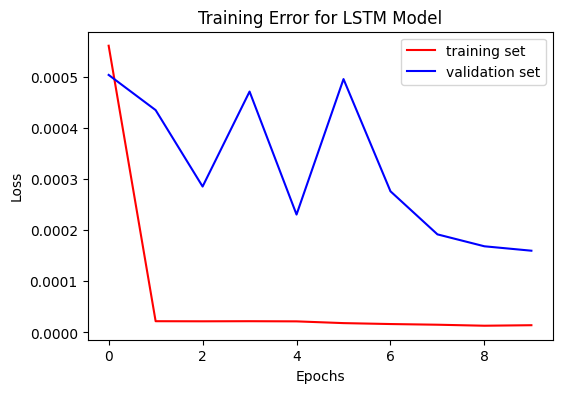

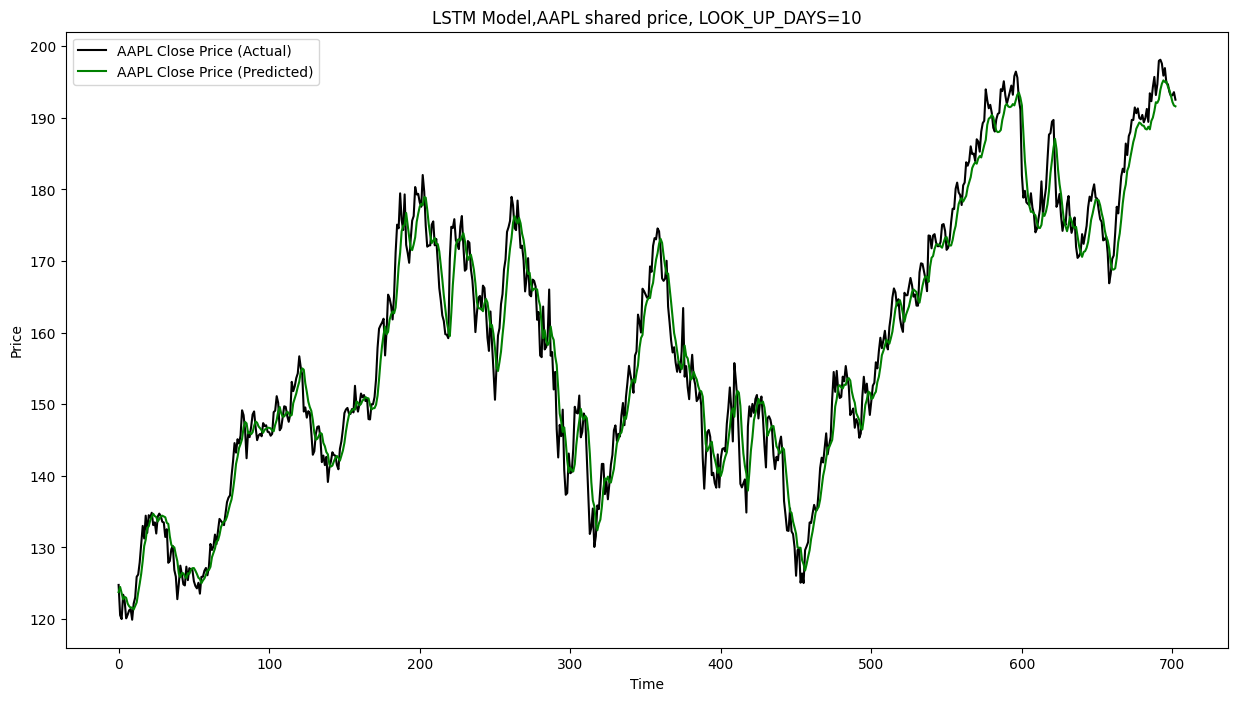

In [199]:
Machine_Learning_1()

## Autoregression Intergrated Moving Average

In [ ]:
p = 1   ## last observation
d = 1   ## Order of differences
q = 2

In [ ]:
arima_mode = ARIMA()